The workflow for a data science project will follow these lines:

1. Get and explore the data
2. Build a model 
3. Train the model
4. Save and predict

## 1. Get and Explore the Data
The first step can take quite some time; data quality is often something that needs to be checked, and correlations between data should often be explored and visualized.

This step can be a full project on its own: you clean the data, make sure you can access it properly, and create visualizations and hypothesis to gain insight into the data that can be shown in a dashboard.

The insight in the data is an essential ingredient for deciding on a model.

## 2. Build a model
Based on domain knowledge and a first exploration of the data, a model can be selected.

Sometimes, the relation between features and outcome is very obvious. You might have features that
correlate very high with the outcome variable, and a domain expert confirms that the correlations make sense.

If this is the case, you can often build a simple model. If you expect to have non-linear and complex interactions between the features,
you could use a model that works with non-linear data like a SVM plus kernel, or a random forest.

If you have enough data (as a rule of thumb, a lower threshold of 1000 observations) you can consider a neural network architecture.
If the expected complexity of the data is low, you can use a relative small network.
If you have lots and lots of data with a high complexity, you should consider to increase the complexity of your model too.

## 3. Train the model
We have seen in the `linearmodel` notebook how we can create a neural network architecture 
from scratch. However, we did not implement this with `jax`. While `jax` is created to build
neural networks from scratch, it is really low-level. We will often be comfortable with having 
a bit more high-level in building the models. 

In this notebook, I will introduce you to PyTorch. Another high level library is Tensorflow, which is used a lot too.
While the interface is comparable, the Tensorflow syntax is a bit more high-level. While this can be an advantage, 
it also has a downside: at the moment you ever need to dive a bit deeper into the architecture itself, it is much harder to
add something new with TensorFlow, compared to PyTorch.

## 4. Save and predict
Finally, you will want to use the trained model to predict new observations.

# Load the data
We will use the fashion MNIST dataset. You will find this dataset a lot in machine learning tutorials. It are small (28x28) images of clothing.

In [1]:
from torchvision.transforms import ToTensor
from torchvision import datasets
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

0.1%

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


83.3%

100.6%
1.0%

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



119.3%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
from torch.utils.data import DataLoader
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [5]:
X, y = next(iter(train_dataloader))
X.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

So, what do we see here? Our datashape has four dimensions:

- 64: this is the batch size. Every batch has 64 observations; in this case 64 images
- 1: this is the channel. Colorimages typically have 3 channels. Our images have just one color, and thus 1 channel. So images can have more channels (e.g. infrared etc)
- (28,28) : this is the actual image, with dimensions 28x28

Lets visualize the first example, the first channel:

<AxesSubplot:>

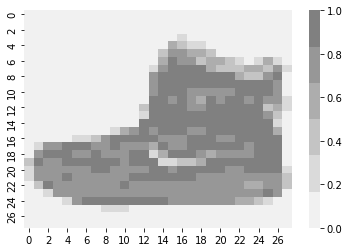

In [24]:
import seaborn as sns
img = X[0][0]
cmap = sns.light_palette("grey")
sns.heatmap(img, cmap=cmap)

# Create a model

In [25]:
import torch
from torch import nn

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Hopefully, you recognize the setup from the `linearmodel` notebook. 

- We will `Flatten` the image. That means we will transform our (64, 1, 28, 28) data into (64, 784) shaped data. What we do here, is flattening the image into a one dimensional vector.
- We have a stack of hidden layers. These are essentially dotproducts. Our vector of 784 (28*28) elements is transformed into 512 elements, and then into 10 elements because we have 10 classes.
- in between the linear transformations you can see the activation functions,here a `ReLu` 
- The `forward` method is what is called during training. This gives you control over the flow of information: it is easy to create some parallel flow of data if you want to do something like that.

# Learn the weights

# Save and predict